# 📦 Projet Data Science – Modèle 4 : Données géographiques et sportives

## ============================
## 🗂️ Phase 1 – Chargement des données
## ============================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## ============================
## 📥 Phase 2 – Import et fusion des données sportives
## ============================

In [4]:
# 📥 Chargement des fichiers
learn_df = pd.read_csv("learn_dataset.csv", sep=";")
sport_df = pd.read_csv("learn_dataset_sport.csv", sep=";")
city_loc_df = pd.read_csv("city_loc.csv", sep=";")
city_adm_df = pd.read_csv("city_adm.csv", sep=";")
city_pop_df = pd.read_csv("city_pop.csv", sep=";")

# ✅ Fusion 1 : learn + sport via UNIQUE_ID (car sport_df n'a pas insee_code)
merged_df = learn_df.merge(sport_df, on="UNIQUE_ID", how="left")

# ✅ Fusion 2 : localisation
merged_df = merged_df.merge(city_loc_df, on="insee_code", how="left")

# ✅ Fusion 3 : administrative
merged_df = merged_df.merge(city_adm_df, on="insee_code", how="left")

# ✅ Fusion 4 : population
merged_df = merged_df.merge(city_pop_df, on="insee_code", how="left")

## ============================
## 🧹 Phase 3 – Prétraitement des variables
## ============================

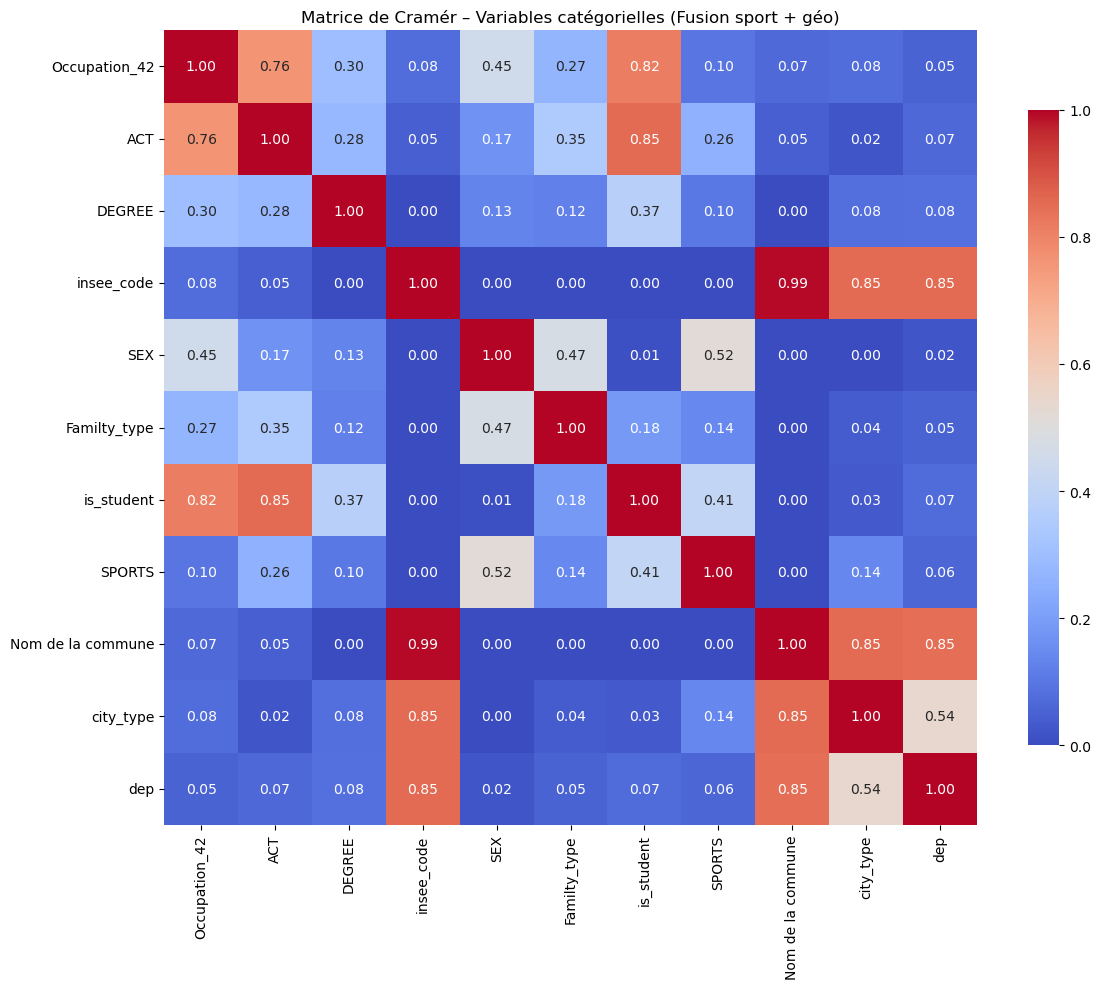

In [6]:
# ============================================
# 🔍 Phase 2bis – Calcul & visualisation de la matrice de Cramér
# ============================================

import seaborn as sns
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """
    Calcule le coefficient de Cramér entre deux colonnes catégorielles x et y.
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Correction de biais
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)
    if min(k_corr - 1, r_corr - 1) <= 0:
        return np.nan
    return np.sqrt(phi2_corr / min(k_corr - 1, r_corr - 1))

# Sélection de toutes les colonnes catégorielles du DataFrame fusionné
cat_cols = merged_df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Initialisation d’un DataFrame pour stocker les coefficients de Cramér
cramer_mat = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

# Remplissage symétrique de la matrice
for i, col1 in enumerate(cat_cols):
    for j, col2 in enumerate(cat_cols):
        if i <= j:
            v = cramers_v(merged_df[col1], merged_df[col2])
            cramer_mat.loc[col1, col2] = v
            cramer_mat.loc[col2, col1] = v

# Visualisation
plt.figure(figsize=(12, 10))
sns.heatmap(
    cramer_mat,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"shrink": 0.8}
)
plt.title("Matrice de Cramér – Variables catégorielles (Fusion sport + géo)")
plt.tight_layout()
plt.show()


In [7]:
def preprocess_data(df):
    data = df.copy()

    if "target" not in data.columns:
        raise ValueError("❌ Colonne 'target' manquante.")

    y = data["target"]
    X = data.drop(columns=["target"])

    # Sélection des types
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    all_cat = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

    # Limiter aux colonnes avec < 100 modalités
    categorical_features = [col for col in all_cat if X[col].nunique() < 100]

    # Pipelines
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ])

    # Transformation finale
    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ])

    X_processed = preprocessor.fit_transform(X)
    return X_processed, y, preprocessor


## ============================
## 🤖 Phase 4 – Modélisation et évaluation
## ============================

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
def train_and_evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("✅ Évaluation du modèle :")
    print(f"R² : {r2_score(y_test, y_pred):.4f}")
    print(f"MAE : {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MSE : {mean_squared_error(y_test, y_pred):.2f}")
    
    return model

# 🧪 Application du pipeline
X4, y4, preproc4 = preprocess_data(merged_df)
model4 = train_and_evaluate_model(X4, y4)

## ============================
## 📊 Phase 5 – Importance des variables sportives
## ============================

In [18]:
importances = model4.feature_importances_
feature_names = preproc4.get_feature_names_out()

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title("Importance des variables – Modèle 4")
plt.tight_layout()
plt.show()

AttributeError: Estimator imputer does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?